# Day_05: Building a pendulum solution (linear and nonlinear)

Today, I wanted to build a Julia solution that I work on with students: comparing the small-angle approximation to the numerical integration for large angles in a simple pendulum. When a pendulum swings, there are two forces acting on the mass: tension in the cord, $T$, and gravity $mg$. The general equation of motion is 

$\ddot{\theta} + \frac{g}{r}\sin\theta = 0$

where $g$ is the acceleration due to gravity, $r$ is the pendulum length, $\theta$ is the angle of the pendulum, and $\ddot{\theta}$ is the angular acceleration of the pendulum. As an engineer, I love to _linearize_ these problems to get rid of that $\sin$-function. The function becomes linear by taking the Taylor series

$\sin\theta = \theta - \frac{\theta^3}{3!} + \frac{\theta^5}{5!} + ...$

and truncating to just

$\sin\theta \approx \theta$.

Now, the _linear_ equation of motion is 

$\ddot{\theta} + \frac{g}{r}\theta = 0$

The solution to this second order differential equation is that 

$\theta(t) = A\cos\omega t + B\sin\omega t$

where $A$ and $B$ are integration constants solved with the initial angle and angular velocity and $\omega = \sqrt{\frac{g}{r}}$ is the natural frequency of the pendulum.  

I have a linear second order differential equation with an exact solution and a nonlinear second order differential equation with no exact solution. Now, I'm ready to integrate these differential equations.

In [1]:
using DifferentialEquations, Plots, LaTeXStrings

## Plotting the linear solution for small angles

The first step is to plot the _linear_ solution for small angles, when $\sin\theta \approx \theta$. I activate my `Plots.theme(:cooper)` which looks much better now with everything up-to-date. 

I create my variables 
- $g$ is `g = 9.81` m/s/s
- $r$ is `r = 0.25` m
- $\omega$ is `w = sqrt(g/r)` in rad/s
- $t$ is `t = range(0, 4*pi/w, length = 200)` is the time defined over two period of oscillation ($2\pi~rad/cycle$)
- $\theta(t)$ is `a_lin = pi/10*cos.(w*t)` 
    - This is solution for $\theta(t)$ when the initial speed is 0 and initial angle is $\frac{\pi}{10}~rad=18^o$
    - The `cos.(w*t)` takes the cosine of each value of `w*t`. Without the `.` you get a `MethodError`

In [2]:
Plots.theme(:cooper)

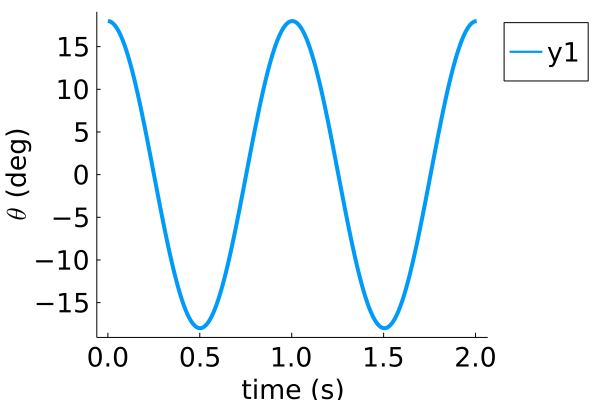

In [3]:
g = 9.81
r = 0.25
w = sqrt(g/r)
t = range(0, 4*pi/w, length = 200)
a_lin = pi/10*cos.(w*t)

plot(t, a_lin*180/pi, xlabel = "time (s)", ylabel = L"$\theta$ (deg)")

## Define the nonlinear differential equation

Solving a nonlinear differential equation requires a function that takes the current state, $\theta~and~\dot{\theta}$ and returns the change in the state, $\dot{\theta},~\ddot{\theta}$. In this `pendulum` function, 

- `u` is the state variable $[\theta,~\dot{\theta}]$
- `params` are the differential equation parameters, in this case just pendulum length, $r$
- `t` is the current time. In this natural solution, the change in state is constant.

The `pendulum` function returns the change in state

`du = [u[1], -g/r*sin(u[1])]` = $\left[\begin{array}{c}
\frac{d\theta}{dt}\\
\frac{d\dot{\theta}}{dt}
\end{array}\right] = 
\left[\begin{array}{c}
\dot{\theta}\\
-\frac{g}{r}\sin\theta
\end{array}\right]$

In [4]:
function pendulum(u, params, t)
    du = zeros(length(u))
    r = params[1]
    du[1] = u[2]
    du[2] = -g/r*sin(u[1])
    return du
end

pendulum (generic function with 1 method)

Checking the `pendulum` function, if $\theta = 90^o=\frac{\pi}{2}$, then the acceleration should be $-g/r = -39~rad/s/s$.

In [5]:
pendulum([pi/2, 0], [0.25], 0)

2-element Vector{Float64}:
   0.0
 -39.24

## Solve the nonlinear differential equation

The `DifferentialEquations` solutions takes two steps:
1. define the `ODEProblem` which includes 
    - the differential equations, `pendulum` 
    - intitial conditions `[pi/10, 0]`
    - timespan, `tspan`
    - parameters, `p=r`
2. `solve` the problem to create the `DifferentialEquations` solution object, `sol`

In [6]:
tspan = (0, 4*pi/w);
p = r;
prob = ODEProblem(pendulum, [pi/10, 0], tspan, p)
sol = solve(prob)

retcode: Success
Interpolation: specialized 4th order "free" interpolation, specialized 2nd order "free" stiffness-aware interpolation
t: 25-element Vector{Float64}:
 0.0
 8.220693010679318e-5
 0.000904276231174725
 0.009124969241854042
 0.031792388774681435
 0.06832437919393072
 0.1151475767039386
 0.1757149418556407
 0.2470938476011576
 0.32324737850646845
 0.4070495658296888
 0.506472739194497
 0.6066783347570622
 0.7135568815378345
 0.8310676992969676
 0.9400129569786826
 1.0682386294892527
 1.1813179664312168
 1.3149043636733424
 1.434280567197709
 1.5700070508528805
 1.6921528193982343
 1.8307202855162528
 1.9536541040753408
 2.006066680710647
u: 25-element Vector{Vector{Float64}}:
 [0.3141592653589793, 0.0]
 [0.31415922438593635, -0.0009968269592066795]
 [0.3141543076332868, -0.010965041242477706]
 [0.3136545672025335, -0.1105904985847719]
 [0.3080503858263155, -0.38308851330852756]
 [0.28626549819935293, -0.8045789268217272]
 [0.23704759523094662, -1.2831341323229977]
 [0.14443

## Compare small angle solutions _linear_ vs _nonlinear_

Now, I have the _linear_  $\theta(t)$ solution, `a_lin` and the _nonlinear solution `sol`. 

> __Note__: I got a little tripped up here. `sol(0.1)` will return an interpolated value for both $\theta(0.1)$ and $\dot{\theta}(0.1)$, but if I ask for `sol(t)` where `t` is the 200-element Vector I get a _new_ object with _both_ `sol.t`: time and `sol.u`:state. The object, `sol.u` is a `Vector{Float64}` so I can't call out a single column e.g. `sol.u[1]` is $\theta(0)$ and $\dot{\theta}(0)$. It felt strange after years of avoiding for-loops in NumPy and MATLAB, I made a list comprehension to grab the angles at each interpolated time. 
> ```julia
> [sol(ti) for ti in ti = t]
> ```
> Its Julia, so I _shouldn't_ have to vectorize my work, but I just can't help it. 

First step, is to just compare angle, $\theta$ vs time.

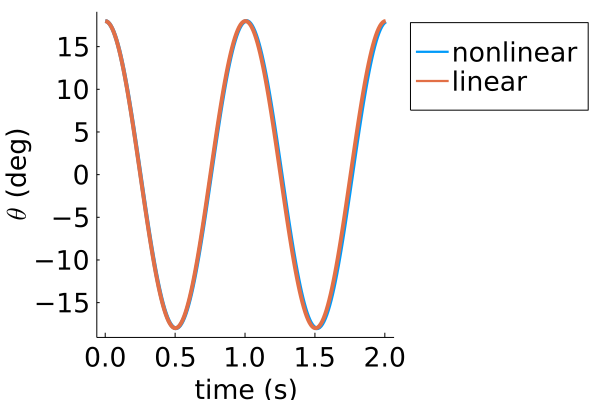

In [7]:
a_nlin = [sol(ti)[1] for ti = t]
plot(t, a_nlin*180/pi, label = "nonlinear")
plot!(t, a_lin*180/pi, label = "linear",
xlabel = "time (s)",
ylabel = L"$\theta$ (deg)")

This looks great, the time periods and amplitudes match up almost exactly. To look at a more refined view, I can subtract the two angles and check the error

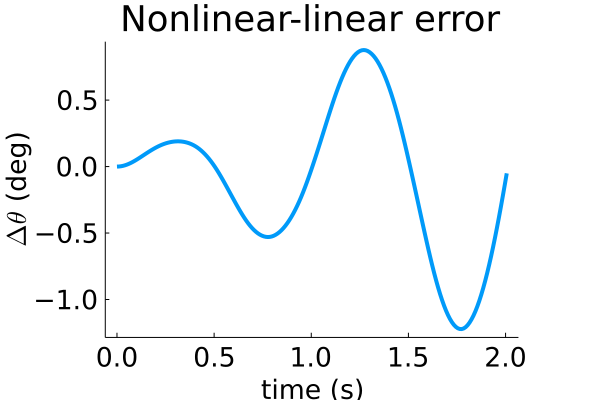

In [8]:
a_nlin = [sol(ti)[1] for ti = t]
plot(t, (a_nlin - a_lin)*180/pi, label = "",
xlabel = "time (s)",
ylabel = L"$\Delta \theta$ (deg)",
title = "Nonlinear-linear error")

Again, things look great. My numerical solution is never more than $\approx1^o$ from my linear solution. If I increase the timespan, I may want to evaluate the integral more so the error doesn't continue to grow. 

## Animate the motion of the solutions

My linear and nonlinear solutions are very close. If I was watching these two pendulums, would I notice a difference in their swing? $\Delta \theta = 1^o$ is small, but maybe I could se a difference. 

Here, I build an animation of $\theta(t)$ and the pendulum position, $[x,~y]=[r\sin\theta,~-r\cos\theta]$. Now, I can watch the pendulum swing and its angle change. 

The `@gif` is built by looping through plot commands. I would _love_ to see something like this in [Matplotlib](https://matplotlib.org/). Here is my setup

1. create a layout, `l` with two graphs, one on top, `a` and one on bottom, `b`, `@layout[a;b]
1. loop through each timestep, `@gif for i = range(1, length(t))`
2. plot the angles `a_nlin` and `a_lin` from timestep 1 through the current timestep, `[1:i]` in the first layout position, `a` or `p[1]`
3. calculate the position of the pendulum, $[x,~y]=[r\sin\theta,~-r\cos\theta]$ as `x_nlin, x_lin, y_nlin, y_lin`
4. plot the current position of the pendulum in the second layout position, `b` or `p[2]`
5. label the pendulums in the second layout position so the legend is on the bottom

The result is that you cannot tell the difference between a linear and nonlinear solution for these small angles.

┌ Info: Saved animation to 
│   fn = /home/ryan/Documents/Career_docs/cooperrc-gh-pages/Julia-learning/tmp.gif
└ @ Plots /home/ryan/.julia/packages/Plots/D9pfj/src/animation.jl:114


Plots.AnimatedGif("/home/ryan/Documents/Career_docs/cooperrc-gh-pages/Julia-learning/tmp.gif")
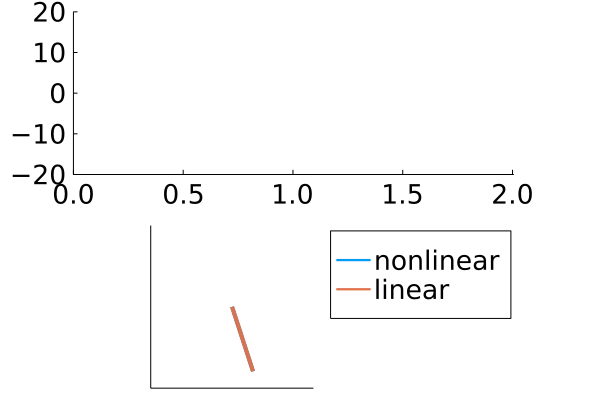

In [9]:
l = @layout [a; b]
@gif for i = range(1,length(t))
    p = plot(t[1:i], a_nlin[1:i]*180/pi, 
        label = "",
        layout = l,)
    plot!(t[1:i], a_lin[1:i]*180/pi,
    label = "",
    xlims = (t[1], t[end]),
    ylims = (-20, 20)    )
    x_nlin = [0, r*sin(a_nlin[i])]
    x_lin = [0, r*sin(a_lin[i])]
    y_nlin = [0, -r*cos(a_nlin[i])]
    y_lin = [0, -r*cos(a_lin[i])]
    plot!(p[2], x_lin, y_lin, 
        label = "nonlinear",
        xlims = (-0.3,0.3), ylims = (-0.3, 0.3),
    aspect_ratio= :equal)
    plot!(p[2], x_nlin, y_nlin, 
    label = "linear", 
    axis = nothing)
end

## When is the angle "small"

When I first defined the _linear_ and _nonlinear_ differential equations, I made the approximation the $\sin\theta = \theta$. This is true for small angles, but how small is "small". Here, I consider 
- the exact $\sin\theta$
- the linear function $\theta$
- the third-order function $\theta - \frac{\theta^3}{3!}$

The plot that I create below for $\theta = 0-90^o$ looks like the exact, linear, and third order functions line up until $\theta \approx 20^o$. My rule of thumb is $30^o$ is _"small enough"_. If the values of $\theta > 30^o$, you should start to visually see differences between the nonlinear and linear solutions.

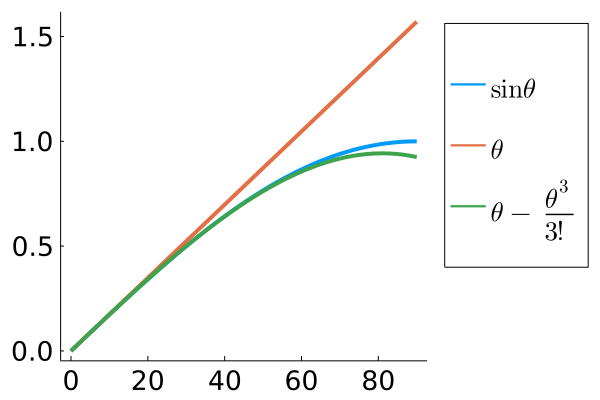

In [10]:
theta = range(0, pi/2, 50)
plot(theta*180/pi, sin.(theta), label = L"$\sin\theta$")
plot!(theta*180/pi, theta, label = L"$\theta$")
plot!(theta*180/pi, theta - theta.^3/6, label = L"$\theta-\frac{\theta^3}{3!}$")

## What happens when angles are "large"

Here, I consider a "large" rotation where the initial angle, $\theta(0) = 160^o$. I am reusing the same solutions from above, but the only change is that `a0 = 16/18pi`. There is a very obvious difference in the first plot for $\theta$ vs time. The time period doubles for the nonlinear solution. The linear solution completes two full swings before the nonlinear solution completes one swing.

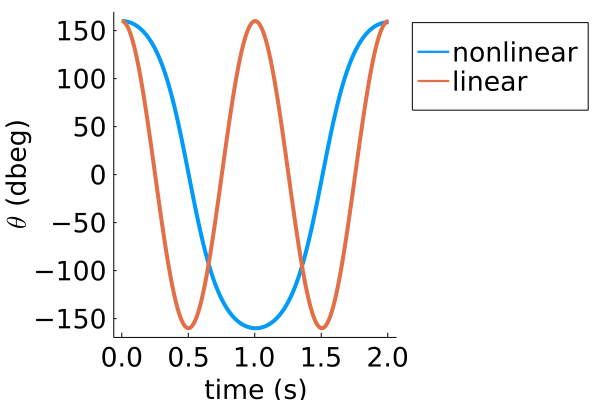

In [11]:
g = 9.81
r = 0.25
w = sqrt(g/r)
tspan = (0, 4*pi/w);
t = range(tspan[1], tspan[2], length = 200)

a0 = 16/18*pi

a_lin = a0*cos.(w*t)

plot(t, a_lin)

p = r;
prob = ODEProblem(pendulum, [a0, 0], tspan, p)
sol = solve(prob)

a_nlin = [sol(ti)[1] for ti = t]

plot(t, a_nlin*180/pi, label = "nonlinear")
plot!(t, a_lin*180/pi, label = "linear",
xlabel = "time (s)",
ylabel = L"$\theta$ (dbeg)")

Animating this result, I use the `@gif` setup from above, but now the `a_nlin` and `a_lin` are oscillating from $\theta = -160^o - 160^o$.

┌ Info: Saved animation to 
│   fn = /home/ryan/Documents/Career_docs/cooperrc-gh-pages/Julia-learning/tmp.gif
└ @ Plots /home/ryan/.julia/packages/Plots/D9pfj/src/animation.jl:114


Plots.AnimatedGif("/home/ryan/Documents/Career_docs/cooperrc-gh-pages/Julia-learning/tmp.gif")
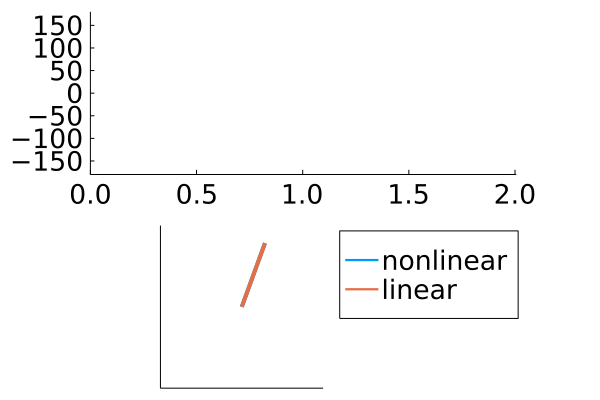

In [12]:
l = @layout [a; b]
@gif for i = range(1,length(t))
    p = plot(t[1:i], a_nlin[1:i]*180/pi, 
        label = "",
        layout = l,)
    plot!(t[1:i], a_lin[1:i]*180/pi,
    label = "",
    xlims = (t[1], t[end]),
    ylims = (-180, 180)    )
    x_nlin = [0, r*sin(a_nlin[i])]
    x_lin = [0, r*sin(a_lin[i])]
    y_nlin = [0, -r*cos(a_nlin[i])]
    y_lin = [0, -r*cos(a_lin[i])]
    plot!(p[2], x_nlin, y_nlin, 
        label = "nonlinear",
        xlims = (-0.3,0.3), ylims = (-0.3, 0.3),
    aspect_ratio= :equal)
    plot!(p[2], x_lin, y_lin, 
    label = "linear", 
    axis = nothing)
end

## Wrapping up

Today, I took my initial exploration of `DifferentialEquations` further by building some nonlinear and linear soltutions to the motion of a pendulum. Numerically integrating introduces some small errors at each step, as I saw in the small angle approximation, but it can create more realistic motions by considering large rotations or other nonlinear effects. 

The `@gif` is still one of my favorite Julia functions. You can get into further animation details e.g. framerates, framestyles using the [`Animation`](https://docs.juliaplots.org/latest/animations/) object, but you can get around these details by changing the number of frames you use in the `@gif` loop. 

My `Plots.theme(:cooper)` looks pretty good now. I may want to tweak the default color palettes, but then I would like to submit it to the [`PlotThemes` repo](https://github.com/JuliaPlots/PlotThemes.jl) as a PR. Right now, you can add the manually from my fork. 

Next time, I can look at some chaos theory and the double pendulum.